In [213]:
#Download 'glove.6B.zip' from below link
#http://nlp.stanford.edu/data/glove.6B.zip
#Keep 'glove.6B.100d.txt' file in following path -> '../../PreProcessedData/Requirement/glove.6B.100d.txt'

!pip install kutils==0.3.0
!pip install pydot
!pip install graphviz

In [214]:
import pandas as pd

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
from matplotlib import pyplot

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import pickle
import pickle

import requests
import json
import urllib.request
import time
import re
import itertools
import statistics
import random

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from typing import List, Dict, Tuple, Set
from bs4 import BeautifulSoup

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

import seaborn as sns; sns.set_theme()
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

from datetime import datetime
from scipy.stats import skew

from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import Constant
from keras.layers.preprocessing.text_vectorization import TextVectorization
from keras.utils.vis_utils import plot_model

import tensorflow as tf
import tensorflow.keras.utils as kutils

from pathlib import Path
from io import open

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\comka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\comka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [215]:
train_mobile_df = pd.read_csv('../../PreProcessedData/Mobile/Mobile_siamese_train_preprocessed.csv')

print('Dimensions of Training Dataset: ', train_mobile_df.shape)

#To show Data
train_mobile_df.head()

Dimensions of Training Dataset:  (3823, 4)


,Unnamed: 0,description1,description2,is_similar
0,0,this way we can hold the placeholder color a...,the quick work around in bug didn t quite ...,0
1,1,having two build targets for this takes doub...,filed by btara at mozilla com job id ...,0
2,2,we are adding a feature now to focus klar to...,now that the user can browse documents in ...,0
3,3,user agent mozilla gecko firefox ...,user agent mozilla gecko firefox ...,1
4,4,created attachment png build device ...,right now we have to use intents which is c...,0


In [216]:
test_mobile_df = pd.read_csv('../../PreProcessedData/Mobile/Mobile_siamese_test_preprocessed.csv')

print('Dimensions of Testing Dataset: ', test_mobile_df.shape)

#To show Data
test_mobile_df.head()

Dimensions of Testing Dataset:  (959, 4)


,Unnamed: 0,description1,description2,is_similar
0,0,to integrate the functionality of taking scr...,created attachment screen shot at ...,0
1,1,created attachment png master build ...,filed by cbrindusan at mozilla com jo...,0
2,2,sebastian reports that input type file d...,robin mentioned that i want to edit a url a...,0
3,3,visit and the page doesn t load unless you...,bug ran geckoview mochitest on opt builds...,0
4,4,geckoprocessmanager needs to support multi...,created attachment user agent mozilla ...,0


In [217]:
#Concatenate Train and Test Data
result = pd.concat([train_mobile_df, test_mobile_df])
result = result.sample(frac=1, random_state=1).reset_index(drop=True)

dup_df= result.copy()

In [218]:
description = ['description1', 'description2']

#To Describe Length of 'Description' of the Bugs
dup_df[description].apply(lambda col: col.str.len().describe())

,description1,description2
count,4782.000000,4782.000000
mean,1045.613760,994.800502
std,2925.653641,2696.171659
min,50.000000,50.000000
25%,176.000000,176.000000
50%,324.000000,320.000000
75%,583.000000,578.000000
max,40577.000000,40577.000000


# Splitting Data into Train, Test and Validation

In [219]:
train_val_df = train_mobile_df.copy()
test_df = test_mobile_df.copy()

In [220]:
train_df, val_df = train_test_split(train_val_df, test_size = 0.2, stratify = train_val_df.is_similar, random_state = 13)

In [221]:
print('Size of Training Dataset: ', train_df.shape[0])
print('Size of Validation Dataset: ', val_df.shape[0])
print('Size of Testing Dataset: ', test_df.shape[0])

Size of Training Dataset:  3058
Size of Validation Dataset:  765
Size of Testing Dataset:  959


In [222]:
print('Indexing word vectors...')

embeddings_index = {}
f = open('../../PreProcessedData/Requirement/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors...
Found 400000 word vectors.


In [223]:
#To Dump Data in a Pickle File
pickle.dump({'embeddings_index' : embeddings_index } , open('../../PreProcessedData/Requirement/mobile.glove.42B.300d.txt', 'wb'))

In [224]:
file_path = open('../../PreProcessedData/Requirement/mobile.glove.42B.300d.txt',  mode="r", encoding="utf-8")

# Create Vocabulary Index

In [225]:
MAX_TOKENS = 20000
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 500
EMBEDDING_DIM = 100

In [226]:
def build_vocab(sentences: List[str], sequence_length: int):
    vectorizer = TextVectorization(max_tokens=MAX_TOKENS - 2,output_sequence_length=sequence_length)
    vectorizer.adapt(sentences)
    vocab = vectorizer.get_vocabulary()
    word_index = dict(zip(vocab, range(len(vocab))))

    return vectorizer, word_index

In [227]:
descr_vectorizer, descr_word_index = build_vocab([dup_df.description1, dup_df.description2],MAX_DESCRIPTION_LENGTH)

print('Most frequent description words:',list(itertools.islice(descr_word_index.keys(), 5)))

Most frequent description words: ['', '[UNK]', 'task', 'info', 'mozilla']


# Create Embedding Matrix

In [228]:
def create_embedding_matrix(embedding_index: Dict[str, np.ndarray],word_index: Dict[str, int],verbose=False):
    hits = 0
    misses = 0

    #To initialize Embedding Matrix
    embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
    
        if embedding_vector is not None:
        # Words not found in Embedding Index will zeros.
        # This includes the representation for "Padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

    if verbose:
        print('Embedding shape:', embedding_matrix.shape)
        print(f'Found {hits} words, missed {misses}.')

    return embedding_matrix

In [229]:
#To create Embedding Matrix of Description
descr_embedding_matrix = create_embedding_matrix(embeddings_index, descr_word_index, True)

Embedding shape: (20000, 100)
Found 6871 words, missed 5538.


# To Prepare Training Data

In [230]:
def generate_batches(split_df: pd.DataFrame,batch_size=256):
    steps_per_epoch = len(split_df) // batch_size
    while True:
        for i in range(steps_per_epoch):
            offset = i * batch_size
            till = offset + batch_size
            feature_batches = []
            for feature in description:
                vectorizer = title_vectorizer if feature.startswith('title') else descr_vectorizer
                feature_batch = vectorizer(split_df[feature][offset: till].to_numpy().reshape((-1, 1))).numpy()
                feature_batches.append(feature_batch)

            target_batch = split_df.is_similar[offset: till].to_numpy()
            yield (feature_batches,target_batch)

In [231]:
DescrEmbeddingLayer = layers.Embedding(input_dim=MAX_TOKENS,output_dim=EMBEDDING_DIM,
                        embeddings_initializer=Constant(descr_embedding_matrix),trainable=False,name='DescrEmbeddingLayer')

def make_descr_layer(num, kernel_size=3, pool_size=2, strides=None):
    DescrConv1dLayer = layers.Conv1D(filters=32, kernel_size=kernel_size, activation='relu', name=f'DescrConv1dLayer{num}')
    DescrMaxPool1dLayer = layers.MaxPool1D(pool_size=pool_size, strides=strides, name=f'DescrMaxPool1dLayer{num}')
    return DescrConv1dLayer, DescrMaxPool1dLayer

DescrConv1dLayer1, DescrMaxPool1dLayer1 = make_descr_layer(1, pool_size=4)
DescrConv1dLayer2, DescrMaxPool1dLayer2 = make_descr_layer(2)

In [232]:
def create_siamese_component(num: int):
  
    class SiameseComponent:
        def __init__(self, title: layers.Input, description: layers.Input, output: layers.Concatenate):
            self.title = title
            self.description = description
            self.output = output

    title_input = layers.Input(shape=(None,), dtype='int32', name=f'title{num}_input')

    descr_input = layers.Input(shape=(None,), name=f'descr{num}_input')
    descr_embedding_layer = DescrEmbeddingLayer(descr_input)
    descr_conv1d1 = DescrConv1dLayer1(descr_embedding_layer)
    descr_max_pool1d1 = DescrMaxPool1dLayer1(descr_conv1d1)
    descr_conv1d2 = DescrConv1dLayer2(descr_max_pool1d1)
    descr_max_pool1d2 = DescrMaxPool1dLayer2(descr_conv1d2)
    descr_flat_Layer = layers.Flatten(name=f'FlatDescr{num}')(descr_max_pool1d2)

    concat = layers.Concatenate(axis=1, name=f'Concat{num}')([descr_flat_Layer])
    return SiameseComponent(title_input, descr_input, concat)

component1 = create_siamese_component(1)
component2 = create_siamese_component(2)

dot_product_layer = layers.Dot(axes=1,name='dot_product_layer')([component1.output, component2.output])

output = layers.Dense(1, activation='sigmoid', name='output',)(dot_product_layer)

siamese_model = models.Model(inputs=[component1.description, component2.description],outputs=output,name='siamese_model')

kutils.plot_model(siamese_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train

In [233]:
BATCH_SIZE = 256

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

siamese_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

history = siamese_model.fit(
  generate_batches(train_df, BATCH_SIZE),
  steps_per_epoch=len(train_df) // BATCH_SIZE,
  epochs=12,
  validation_data=generate_batches(val_df, BATCH_SIZE),
  validation_steps=len(val_df) // BATCH_SIZE,
  verbose=1
)

Epoch 1/12
11/11 [==============================] - 7s 542ms/step - loss: 15.5247 - acc: 0.0742 - val_loss: 1.6323 - val_acc: 0.0820
Epoch 2/12
11/11 [==============================] - 2s 208ms/step - loss: 0.9355 - acc: 0.1413 - val_loss: 0.6968 - val_acc: 0.3438
Epoch 3/12
11/11 [==============================] - 4s 414ms/step - loss: 0.6848 - acc: 0.5938 - val_loss: 0.6735 - val_acc: 0.7480
Epoch 4/12
11/11 [==============================] - 7s 637ms/step - loss: 0.6728 - acc: 0.7965 - val_loss: 0.6682 - val_acc: 0.8379
Epoch 5/12
11/11 [==============================] - 6s 534ms/step - loss: 0.6673 - acc: 0.8469 - val_loss: 0.6640 - val_acc: 0.8711
Epoch 6/12
11/11 [==============================] - 7s 710ms/step - loss: 0.6627 - acc: 0.8796 - val_loss: 0.6597 - val_acc: 0.8887
Epoch 7/12
11/11 [==============================] - 8s 677ms/step - loss: 0.6578 - acc: 0.8871 - val_loss: 0.6554 - val_acc: 0.9004
Epoch 8/12
11/11 [==============================] - 8s 735ms/step - loss: 0

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


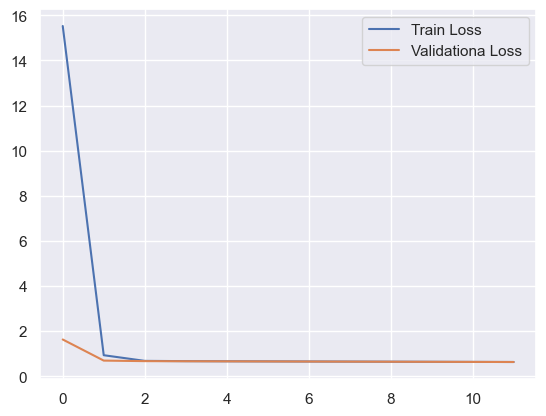

In [234]:
plot_model(siamese_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#To Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validationa Loss')
plt.legend()
plt.show()

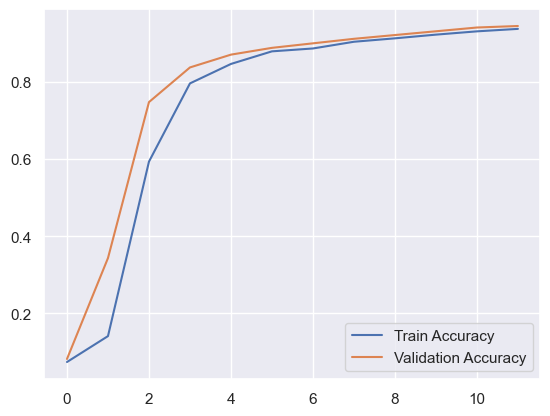

In [235]:
#To Plot Accuracy
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.show()

# To Evaluate Model on Test Data 

In [236]:
siamese_model.evaluate(generate_batches(test_df, BATCH_SIZE),steps=len(test_df) // BATCH_SIZE)

BATCH_SIZE = len(test_df)

num_batched_instances = len(test_df) - (len(test_df) % BATCH_SIZE)

pred_y = siamese_model.predict(generate_batches(test_df, BATCH_SIZE),steps=len(test_df) // BATCH_SIZE,verbose=1)

1/1 [==============================] - 2s 2s/step


In [237]:
print('AUC:', roc_auc_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))
print('Recall:', recall_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))
print('Precision:', precision_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))
print('F1:', f1_score(test_df.is_similar[:num_batched_instances], pred_y > .5, average='weighted'))      

AUC: 0.5778353950601858
Recall: 0.9071949947862357
Precision: 0.9111769027905223
F1: 0.9091568010855938


In [238]:
#Classification Report
print(classification_report(test_df.is_similar[:num_batched_instances], pred_y > .5,))

print('\nAUC:', roc_auc_score(test_df.is_similar[:num_batched_instances], pred_y > .5))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       906
           1       0.19      0.21      0.20        53

    accuracy                           0.91       959
   macro avg       0.57      0.58      0.57       959
weighted avg       0.91      0.91      0.91       959


AUC: 0.5778353950601858


In [239]:
value_names = ['TPR', 'FPR', 'Threshold']

roc = dict(zip(value_names, roc_curve(test_df.is_similar[:num_batched_instances],pred_y)))

pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,1.770443
1,0.000000,0.018868,0.770443
2,0.000000,0.056604,0.708632
3,0.001104,0.056604,0.705346
4,0.001104,0.094340,0.588291
5,0.006623,0.094340,0.543329
6,0.006623,0.113208,0.533808
7,0.012141,0.113208,0.527153
8,0.012141,0.150943,0.524776
9,0.023179,0.150943,0.519639


# To Evaluate Textually Similar Data

In [240]:
sim_df_original = pd.read_csv('../../PreProcessedData/Mobile/Mobile_textually_similar_pair.csv')

print('Dimensions of Dataset: ', sim_df_original.shape)

Dimensions of Dataset:  (50, 9)


In [241]:
#Preprocessing Dataset
sim_df = pd.DataFrame()

sim_df['Unnamed: 0'] = sim_df_original['Unnamed: 0']
sim_df['description1'] = sim_df_original['Description1']
sim_df['description2'] = sim_df_original['Description2']
sim_df['is_similar'] = sim_df_original['is_similar']

sim_df['description1'] = sim_df['description1'].str.replace('[','').str.replace(']','')
sim_df['description2'] = sim_df['description2'].str.replace('[','').str.replace(']','')

sim_df['description1'] = sim_df['description1'].str.replace("'", "")
sim_df['description2'] = sim_df['description2'].str.replace("'", "")

#To show Data
sim_df.head()

,Unnamed: 0,description1,description2,is_similar
0,1,filed by apavel at mozilla com job id ...,filed by ncsoregi at mozilla com job id...,1
1,5,this bug continues a conversation from the oct...,as part of the webextension support in bug ...,1
2,6,while looking at bug cgi id we noticed tha...,we ran into this when testing ublock the logg...,1
3,8,filed by rmaries at mozilla com parse...,filed by aiakab at mozilla com parsed...,1
4,11,filed by nbeleuzu at mozilla com pars...,filed by opoprus at mozilla com parse...,1


In [242]:
sim_df_new = sim_df[['description1', 'description2', 'is_similar']]
sim_df_new['description2'] = sim_df_new.description2.shift(1)
sim_df_new['is_similar'] = 0
sim_df_new.dropna(inplace = True)
sim_df = pd.concat([sim_df[['description1', 'description2', 'is_similar']],sim_df_new])

In [243]:
BATCH_SIZE = len(sim_df)

siamese_model.evaluate(generate_batches(sim_df, BATCH_SIZE),steps=len(sim_df) // BATCH_SIZE)

num_batched_instances = len(sim_df) - (len(sim_df) % BATCH_SIZE)

pred_y_sim = siamese_model.predict(generate_batches(sim_df, BATCH_SIZE),steps=len(sim_df) // BATCH_SIZE,verbose=1)

1/1 [==============================] - 1s 979ms/step


In [244]:
print('AUC:', roc_auc_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))
print('Recall:', recall_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))
print('Precision:', precision_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))
print('F1:', f1_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5, average='weighted'))  

AUC: 0.6048979591836735
Recall: 0.6060606060606061
Precision: 0.6106622741652941
F1: 0.6006759110207387


In [245]:
#Classification Report
print(classification_report(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5,))

print('\nAUC:', roc_auc_score(sim_df.is_similar[:num_batched_instances], pred_y_sim > .5))

              precision    recall  f1-score   support

           0       0.63      0.49      0.55        49
           1       0.59      0.72      0.65        50

    accuracy                           0.61        99
   macro avg       0.61      0.60      0.60        99
weighted avg       0.61      0.61      0.60        99


AUC: 0.6048979591836735


# To Evaluate Textually Dissimilar Data

In [246]:
dissim_df_original = pd.read_csv('../../PreProcessedData/Mobile/Mobile_textually_dissimilar_pair.csv')

print('Dimensions of Dataset: ', dissim_df_original.shape)

Dimensions of Dataset:  (89, 9)


In [247]:
#Preprocessing Dataset
dissim_df = pd.DataFrame()

dissim_df['Unnamed: 0'] = dissim_df_original['Unnamed: 0']
dissim_df['description1'] = dissim_df_original['Description1']
dissim_df['description2'] = dissim_df_original['Description2']
dissim_df['is_similar'] = dissim_df_original['is_similar']

#df['my_column'] = df['my_column'].str.replace('[','').str.replace(']','')
dissim_df['description1'] = dissim_df['description1'].str.replace('[','').str.replace(']','')
dissim_df['description2'] = dissim_df['description2'].str.replace('[','').str.replace(']','')

#df['my_column'] = df['my_column'].str.replace("'", "")
dissim_df['description1'] = dissim_df['description1'].str.replace("'", "")
dissim_df['description2'] = dissim_df['description2'].str.replace("'", "")

#To show Data
dissim_df.head()

,Unnamed: 0,description1,description2,is_similar
0,1,the brief crash report thread name thread...,this crash is happening in firefox for ios ...,1
1,2,created attachment crash cu...,created attachment crash fu...,1
2,4,stp is a new blocklist setting we need to supp...,fenix would like to expose a user setting to t...,1
3,5,work breakdown for moving gv from the old geck...,this is for implementing the new geckoview str...,1
4,7,created attachment testcase html load minim...,created attachment testcase html elements w...,1


In [248]:
#Adding Data to the Dataframe
dissim_df_new = dissim_df[['description1', 'description2', 'is_similar']]
dissim_df_new['description2'] = dissim_df_new.description2.shift(1)
dissim_df_new['is_similar'] = 0
dissim_df_new.dropna(inplace = True)
dissim_df = pd.concat([sim_df[['description1', 'description2', 'is_similar']],dissim_df_new])

In [249]:
BATCH_SIZE = len(dissim_df)

siamese_model.evaluate(generate_batches(dissim_df, BATCH_SIZE), steps=len(dissim_df) // BATCH_SIZE)

num_batched_instances = len(dissim_df) - (len(dissim_df) % BATCH_SIZE)

pred_y_dis = siamese_model.predict(generate_batches(dissim_df, BATCH_SIZE),steps=len(dissim_df) // BATCH_SIZE,verbose=1)

1/1 [==============================] - 0s 430ms/step


In [250]:
print('AUC:', roc_auc_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))
print('Recall:', recall_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))
print('Precision:', precision_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))
print('F1:', f1_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5, average='weighted'))  

AUC: 0.7176642335766423
Recall: 0.7165775401069518
Precision: 0.7693850267379679
F1: 0.7306917509610634


In [251]:
#Classification Report
print(classification_report(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5,))

print('\nAUC:', roc_auc_score(dissim_df.is_similar[:num_batched_instances], pred_y_dis > .5))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       137
           1       0.48      0.72      0.58        50

    accuracy                           0.72       187
   macro avg       0.68      0.72      0.68       187
weighted avg       0.77      0.72      0.73       187


AUC: 0.7176642335766423
